In [1]:
import requests
import pandas as pd
import time
import Levenshtein
from tqdm import tqdm  # Import tqdm for progress bar
import os
import zipfile
import matplotlib.pyplot as plt

## File unzipping and opening 

In [2]:


def unpack_zip_to_parent(zip_path):
    """Unpacks the given .zip file to the parent directory of the current folder."""
    
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)

    # Ensure the zip file exists
    if not os.path.isfile(zip_path):
        print(f"Error: File '{zip_path}' not found.")
        return

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(parent_dir)
        print(f"Successfully extracted '{zip_path}' to '{parent_dir}'")
    except zipfile.BadZipFile:
        print("Error: Not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred: {e}")

zip_file = "archive.zip"
unpack_zip_to_parent(zip_file)


Error: File 'archive.zip' not found.


In [3]:
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
file_path = os.path.join(parent_directory, "Books.csv")
book_df = pd.read_csv(file_path)

C:\Users\danny\AppData\Local\Temp\ipykernel_20600\3210800039.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_df = pd.read_csv(file_path)


In [4]:
file_path = os.path.join(parent_directory, "Users.csv")
user_df = pd.read_csv(file_path)

In [5]:
file_path = os.path.join(parent_directory, "Ratings.csv")
ratings_df = pd.read_csv(file_path)

### BOOK DATAFRAME ( Ties ISBN to info on books ) 

In [6]:
book_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
book_df['Book-Author'].value_counts()

## Agatha Christie had over 100 books, but not over 600.  So there will be some cleaning we need to do here. 

Book-Author
Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
                       ... 
Linda Jackson             1
Artiste C. Arthur         1
Emily Pearl Kingsley      1
Jean Cassels              1
Christopher  Biffle       1
Name: count, Length: 102022, dtype: int64

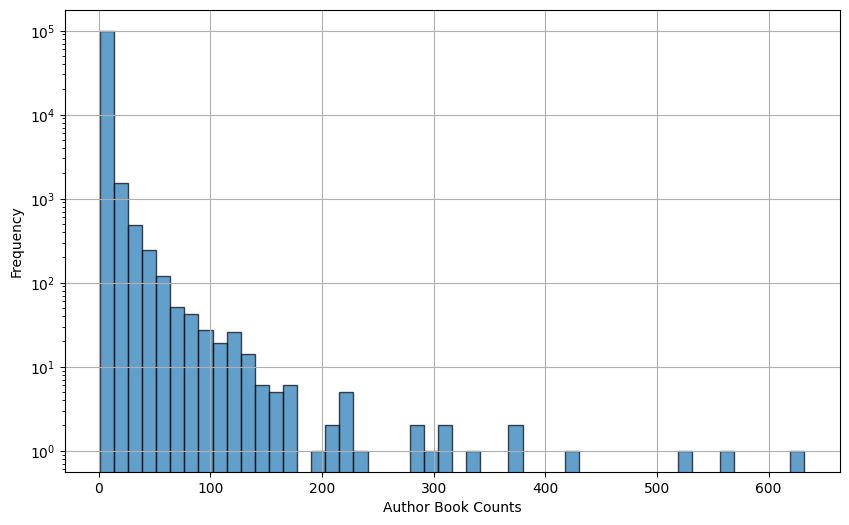

In [8]:
author_counts = book_df['Book-Author'].value_counts()


plt.figure(figsize=(10, 6))
plt.hist(author_counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Author Book Counts')
plt.ylabel('Frequency')
plt.title('')
plt.yscale('log') 
plt.grid(True)
plt.show()


In [9]:
duplicates = book_df.groupby('Book-Title')['ISBN'].nunique()
multiple_isbns = duplicates[duplicates > 1]

# see where books have multiple isbns
duped_titles = book_df[book_df['Book-Title'].isin(multiple_isbns.index)].sort_values(by = 'Book-Title')
duped_titles[duped_titles['Book-Author']=='Agatha Christie']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
63364,0671414925,A B C MURDERS,Agatha Christie,1980,Pocket,http://images.amazon.com/images/P/0671414925.0...,http://images.amazon.com/images/P/0671414925.0...,http://images.amazon.com/images/P/0671414925.0...
76207,0671829653,A B C MURDERS,Agatha Christie,1979,Pocket,http://images.amazon.com/images/P/0671829653.0...,http://images.amazon.com/images/P/0671829653.0...,http://images.amazon.com/images/P/0671829653.0...
96304,0671464779,A B C MURDERS,Agatha Christie,1982,Pocket,http://images.amazon.com/images/P/0671464779.0...,http://images.amazon.com/images/P/0671464779.0...,http://images.amazon.com/images/P/0671464779.0...
123379,0061003654,A Caribbean Mystery,Agatha Christie,1992,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061003654.0...,http://images.amazon.com/images/P/0061003654.0...,http://images.amazon.com/images/P/0061003654.0...
133224,0671469207,A Caribbean Mystery,Agatha Christie,1982,Pocket,http://images.amazon.com/images/P/0671469207.0...,http://images.amazon.com/images/P/0671469207.0...,http://images.amazon.com/images/P/0671469207.0...
...,...,...,...,...,...,...,...,...
252857,0671556452,What Mrs. McGillicuddy Saw,Agatha Christie,1984,Pocket,http://images.amazon.com/images/P/0671556452.0...,http://images.amazon.com/images/P/0671556452.0...,http://images.amazon.com/images/P/0671556452.0...
28340,0425098559,Why Didn't They Ask Evans?,Agatha Christie,1992,Berkley Publishing Group,http://images.amazon.com/images/P/0425098559.0...,http://images.amazon.com/images/P/0425098559.0...,http://images.amazon.com/images/P/0425098559.0...
96302,0440107040,Why Didn't They Ask Evans?,Agatha Christie,1982,Bantam Books (Mm),http://images.amazon.com/images/P/0440107040.0...,http://images.amazon.com/images/P/0440107040.0...,http://images.amazon.com/images/P/0440107040.0...
15452,0553350072,Witness for the Prosecution,Agatha Christie,1987,Bantam Doubleday Dell,http://images.amazon.com/images/P/0553350072.0...,http://images.amazon.com/images/P/0553350072.0...,http://images.amazon.com/images/P/0553350072.0...


In [10]:
book_df = book_df.sort_values(by=['Book-Author', 'Book-Title', 'ISBN'])
book_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
18118,0312956762,Die Hard: With a Vengeance - A Novel,D. Chiel,1995,St Martins Pr,http://images.amazon.com/images/P/0312956762.0...,http://images.amazon.com/images/P/0312956762.0...,http://images.amazon.com/images/P/0312956762.0...
232912,034545006X,The Taking,J. D. Landis,2003,Ballantine Books,http://images.amazon.com/images/P/034545006X.0...,http://images.amazon.com/images/P/034545006X.0...,http://images.amazon.com/images/P/034545006X.0...
107022,1579651372,Ruskin's Rose: A Venetian Love Story,Mimma Balia,2000,Artisan Publishers,http://images.amazon.com/images/P/1579651372.0...,http://images.amazon.com/images/P/1579651372.0...,http://images.amazon.com/images/P/1579651372.0...
99357,0440416361,Nsync : The Official Book,'N Sync,1998,Delacorte Press,http://images.amazon.com/images/P/0440416361.0...,http://images.amazon.com/images/P/0440416361.0...,http://images.amazon.com/images/P/0440416361.0...
224536,0972066713,The Mom-to-Mom Guide to the Baby Years: Review...,142 moms from all over the world,2002,"Sound Bite Press, Inc.",http://images.amazon.com/images/P/0972066713.0...,http://images.amazon.com/images/P/0972066713.0...,http://images.amazon.com/images/P/0972066713.0...
...,...,...,...,...,...,...,...,...
191514,3518188070,"Suhrkamp BasisBibliothek (SBB), Nr.7, Jugend o...",Ã?Â?dÃ?Â¶n von Horvath,1999,Suhrkamp,http://images.amazon.com/images/P/3518188070.0...,http://images.amazon.com/images/P/3518188070.0...,http://images.amazon.com/images/P/3518188070.0...
139818,2268045757,Maximes et pensÃ?Â©es : Ã?Â?pictÃ?Â¨te,Ã?Â?pictÃ?Â¨te,2003,Editions du Rocher,http://images.amazon.com/images/P/2268045757.0...,http://images.amazon.com/images/P/2268045757.0...,http://images.amazon.com/images/P/2268045757.0...
33914,2290048763,Mademoiselle Chambon,Ã?Â?ric Holder,1998,J'ai lu,http://images.amazon.com/images/P/2290048763.0...,http://images.amazon.com/images/P/2290048763.0...,http://images.amazon.com/images/P/2290048763.0...
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...


### Ratings df , ties User-ID to ISBNs and ratings theyve had. 

In [11]:
ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [12]:
ratings_df['User-ID'].value_counts()

### so we'll want to be aware of both the cold-start problem, 
### and some readers who might either be bots or just anomalies

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

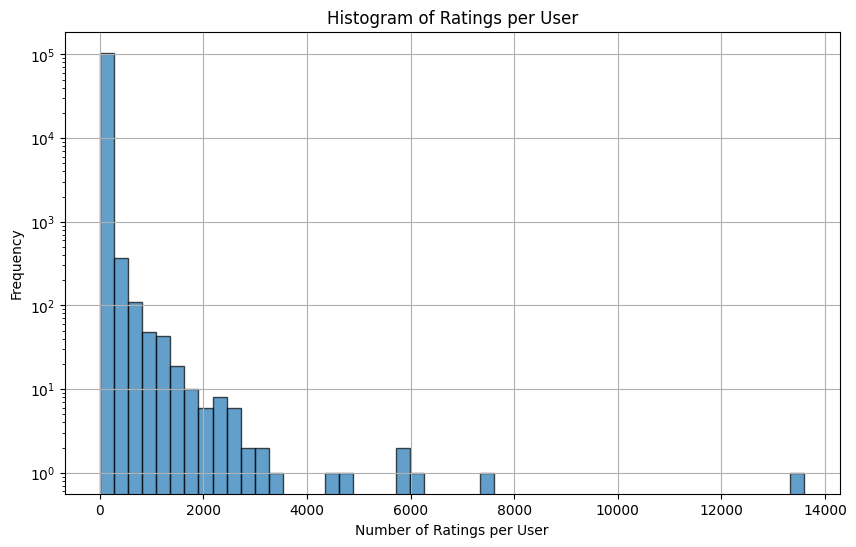

In [13]:
import matplotlib.pyplot as plt


user_id_counts = ratings_df['User-ID'].value_counts()


plt.figure(figsize=(10, 6))
plt.hist(user_id_counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings per User')
plt.yscale('log')  # Log scale to better visualize the distribution
plt.grid(True)
plt.show()


### User Metadata

In [14]:
user_df

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


## Merging

In [15]:
df = ratings_df.merge(book_df,
                  left_on="ISBN",
                  right_on="ISBN").merge(
                      user_df,left_on='User-ID',right_on='User-ID')

In [16]:
df.head(3)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  int64  
 3   Book-Title           1031136 non-null  object 
 4   Book-Author          1031134 non-null  object 
 5   Year-Of-Publication  1031136 non-null  object 
 6   Publisher            1031134 non-null  object 
 7   Image-URL-S          1031136 non-null  object 
 8   Image-URL-M          1031136 non-null  object 
 9   Image-URL-L          1031132 non-null  object 
 10  Location             1031136 non-null  object 
 11  Age                  753301 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 94.4+ MB


In [17]:
for i in df.columns:
    print(i,"percent missing: ",(len(df[df[i].isna()])/len(df)))
    

User-ID percent missing:  0.0
ISBN percent missing:  0.0
Book-Rating percent missing:  0.0
Book-Title percent missing:  0.0
Book-Author percent missing:  1.9396083542811036e-06
Year-Of-Publication percent missing:  0.0
Publisher percent missing:  1.9396083542811036e-06
Image-URL-S percent missing:  0.0
Image-URL-M percent missing:  0.0
Image-URL-L percent missing:  3.879216708562207e-06
Location percent missing:  0.0
Age percent missing:  0.2694455435558452


In [18]:
df[df['Book-Author'].isna()]

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
244331,63714,0751352497,10,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,"milton keynes, england, united kingdom",29.0
369234,98647,9627982032,8,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,"selayang, selangor, malaysia",26.0


In [19]:
df = df.dropna(subset=['Book-Author'])
df.drop(['Image-URL-M','Image-URL-L'],axis=1,inplace=True)

### AGE IS MISSING LIKE 25% of the time, so we can decide if we want to use it or not. 

#### Goal:  Ensure every row corresponding to the same Book-Title and Book-Author has a consistent ISBN across all user reviews.   However, avoid mistakenly merging books with the same title but different authors. 

In [20]:

## This should only be run once, if it works. 

'''
#### Identify Duplicates (Same Title + Author, Different ISBN)
isbn_counts = df.groupby(['Book-Title', 'Book-Author'])['ISBN'].nunique()
duplicate_books = isbn_counts[isbn_counts > 1].index  # Titles with multiple ISBNs

#### Choose a Representative ISBN for Each Title-Author Combo
isbn_mapping = {}

for title, author in tqdm(duplicate_books, desc="Processing Duplicate Books", unit="book"):
    subset = df[(df['Book-Title'] == title) & (df['Book-Author'] == author)]
    
    # Pick the most frequent ISBN, fallback to earliest ISBN if there's a tie
    common_isbn = subset['ISBN'].value_counts().idxmax()
    
    # Store mapping
    isbn_mapping[(title, author)] = common_isbn

#### Replace ISBNs in DataFrame
df['ISBN_fix'] = df.apply(
    lambda row: isbn_mapping.get((row['Book-Title'], row['Book-Author']), row['ISBN']),
    axis=1
)
'''


'\n#### Identify Duplicates (Same Title + Author, Different ISBN)\nisbn_counts = df.groupby([\'Book-Title\', \'Book-Author\'])[\'ISBN\'].nunique()\nduplicate_books = isbn_counts[isbn_counts > 1].index  # Titles with multiple ISBNs\n\n#### Choose a Representative ISBN for Each Title-Author Combo\nisbn_mapping = {}\n\nfor title, author in tqdm(duplicate_books, desc="Processing Duplicate Books", unit="book"):\n    subset = df[(df[\'Book-Title\'] == title) & (df[\'Book-Author\'] == author)]\n    \n    # Pick the most frequent ISBN, fallback to earliest ISBN if there\'s a tie\n    common_isbn = subset[\'ISBN\'].value_counts().idxmax()\n    \n    # Store mapping\n    isbn_mapping[(title, author)] = common_isbn\n\n#### Replace ISBNs in DataFrame\ndf[\'ISBN_fix\'] = df.apply(\n    lambda row: isbn_mapping.get((row[\'Book-Title\'], row[\'Book-Author\']), row[\'ISBN\']),\n    axis=1\n)\n'

In [21]:
#isbn_df = pd.DataFrame(isbn_mapping.items(), columns=['Title_Author', 'ISBN'])
#isbn_df.to_csv("isbn_mapping.csv", index=False)

In [22]:
loaded_mapping_df = pd.read_csv("isbn_mapping.csv")
loaded_mapping = dict(zip(loaded_mapping_df['Title_Author'], loaded_mapping_df['ISBN']))


In [23]:
df['Title_Author'] = df['Book-Title'] + " || " + df['Book-Author']  # Match format used in mapping
df['ISBN_fix'] = df['Title_Author'].map(loaded_mapping).fillna(df['ISBN'])
df.drop(columns=['Title_Author'], inplace=True)

## HOPEFULLY, the mapping should be fixed now. 

In [24]:
df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Location,Age,ISBN_fix
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN,034545104X
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",NaN,0155061224
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0,0446520802
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0,052165615X
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0,0521795028
...,...,...,...,...,...,...,...,...,...,...,...
1031131,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,"cedar park, texas, usa",NaN,0876044011
1031132,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,"cedar park, texas, usa",NaN,1563526298
1031133,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,"quebec, quebec, canada",18.0,0679447156
1031134,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...,"mannington, west virginia, usa",38.0,0515107662


In [25]:
## mapping 

df['User-ID'].value_counts()

User-ID
11676     11144
198711     6456
153662     5814
98391      5779
35859      5646
          ...  
116792        1
116798        1
116801        1
116810        1
276721        1
Name: count, Length: 92106, dtype: int64

In [26]:
df[df['User-ID']==11676]

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Location,Age,ISBN_fix
39818,11676,0001837397,0,Autumn Story Brambly Hedge,Jill Barklem,0,William Collins Sons Co Ltd,http://images.amazon.com/images/P/0001837397.0...,"n/a, n/a, n/a",NaN,0001837397
39819,11676,0001841572,0,Red Shift,Alan Garner,1973,Collins,http://images.amazon.com/images/P/0001841572.0...,"n/a, n/a, n/a",NaN,0001841572
39820,11676,0001848445,0,THE COAL HOUSE T/PB,Andrew Taylor,1986,HarperCollins Publishers,http://images.amazon.com/images/P/0001848445.0...,"n/a, n/a, n/a",NaN,0001848445
39821,11676,0001900277,0,Glue (First Facts - First Skills),Harriet Hains,1989,HarperCollins Publishers,http://images.amazon.com/images/P/0001900277.0...,"n/a, n/a, n/a",NaN,0001900277
39822,11676,0001941941,0,Little Grey Rabbit's Christmas (Collins Colour...,Alison Uttley,1978,HarperCollins Publishers,http://images.amazon.com/images/P/0001941941.0...,"n/a, n/a, n/a",NaN,0001941941
...,...,...,...,...,...,...,...,...,...,...,...
50957,11676,9879397274,7,Desde Mi Cielo,Alice Sebold,2003,Mondadori (IT),http://images.amazon.com/images/P/9879397274.0...,"n/a, n/a, n/a",NaN,9879397274
50958,11676,987960170X,5,Kolon,Raul Alberto Lilloy,1996,Ediciones Riverrum,http://images.amazon.com/images/P/987960170X.0...,"n/a, n/a, n/a",NaN,987960170X
50959,11676,9974643058,7,La piel dura,Andrea BlanquÃ©,1999,Planeta,http://images.amazon.com/images/P/9974643058.0...,"n/a, n/a, n/a",NaN,9974643058
50960,11676,9997511417,0,A Bundle for the Toff,John Creasey,1968,Walker &amp; Co,http://images.amazon.com/images/P/9997511417.0...,"n/a, n/a, n/a",NaN,9997511417


In [27]:
df['Location'].value_counts()
## maybe we can clean this to start, country, or drop.  

Location
toronto, ontario, canada          14782
n/a, n/a, n/a                     11162
chicago, illinois, usa             8499
seattle, washington, usa           8392
ottawa, ontario, canada            8116
                                  ...  
chicago, indiana, usa                 1
hueytown, alabama, usa                1
lyons, ,                              1
arcadia, indiana, usa                 1
mannington, west virginia, usa        1
Name: count, Length: 22480, dtype: int64

In [28]:
df[df['Year-Of-Publication']==0].sort_values(by='Book-Rating',ascending=False)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Location,Age,ISBN_fix
298774,79057,0571081789,10,Bell Jar,Sylvia Plath,0,Faber Faber Inc,http://images.amazon.com/images/P/0571081789.0...,"lisboa, n/a, portugal",37.0,0571081789
50045,11676,3423105518,10,Name Der Rose,Umberto Eco,0,Distribooks Int'l+inc,http://images.amazon.com/images/P/3423105518.0...,"n/a, n/a, n/a",NaN,3423105518
212122,55331,3596214629,10,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3596214629.0...,"vellmar, hessen, germany",35.0,3596214629
523950,141203,3596294339,10,Der Zauberberg,Thomas Mann,0,Fischer Taschenbuch Verlag,http://images.amazon.com/images/P/3596294339.0...,"hamburg, hamburg, germany",38.0,3596294339
895079,239594,359621078X,10,Saemtliche Erzaehlungen,Franz Kafka,0,Fischer Taschenbuch Verlag,http://images.amazon.com/images/P/359621078X.0...,"leuven, vlaams-brabant, belgium",28.0,359621078X
...,...,...,...,...,...,...,...,...,...,...,...
403421,108023,0571176607,0,Aunt Margarets Lover,Mavis Cheek,0,Faber Faber Inc,http://images.amazon.com/images/P/0571176607.0...,"stansted mountfitchet, england, united kingdom",59.0,0571176607
403439,108083,0006550924,0,Seven Years In Tibet,Heinrich Harrer,0,Flamingo,http://images.amazon.com/images/P/0006550924.0...,"red deer, alberta, canada",NaN,0006550924
403651,108155,1559029838,0,Call of the Wild,Jack London,0,Selldowns/no More Orders,http://images.amazon.com/images/P/1559029838.0...,"indianapolis, indiana, usa",29.0,1559029838
403825,108243,059022297X,0,Town Mouse Country Mouse,Jan Brett,0,Scholastic Inc,http://images.amazon.com/images/P/059022297X.0...,"canton, ga, usa",14.0,059022297X


In [29]:
### so maybe a API call and go off of the ISBN,  then use something simple like
#  levenschtein distance to make sure the book title and author are close before using data for the fixed Year-Of-Publication


### we can also use the levenschtein distance or something similar to determine if there's any books that are really close in title and author but have differnt isbns 


In [30]:
'''

# Google Books API Base URL
GOOGLE_BOOKS_API_URL = "https://www.googleapis.com/books/v1/volumes"

import os
current_dir = os.getcwd()
parent_folder = os.path.dirname(current_dir)
file_path = os.path.join(parent_folder, 'dans_api_key.txt')
with open(file_path, 'r') as file:
    API_KEY = file.read()
'''

'\n\n# Google Books API Base URL\nGOOGLE_BOOKS_API_URL = "https://www.googleapis.com/books/v1/volumes"\n\nimport os\ncurrent_dir = os.getcwd()\nparent_folder = os.path.dirname(current_dir)\nfile_path = os.path.join(parent_folder, \'dans_api_key.txt\')\nwith open(file_path, \'r\') as file:\n    API_KEY = file.read()\n'

In [31]:
df_backup = df.copy(deep=True)
df_backup.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Location,Age,ISBN_fix
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN,034545104X
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",NaN,0155061224
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0,0446520802
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0,052165615X
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0,0521795028


In [32]:
'''
# Create combined title-author field for checking similarity
df["Title_Author"] = df["Book-Title"].fillna('') + " " + df["Book-Author"].fillna('')

# Ensure ISBN_fix column exists and clean it
df["ISBN_fix"] = df["ISBN_fix"].astype(str).str.strip()

# Define conditions for when to query the API
def needs_imputation(year):
    return pd.isna(year) or str(year).strip() in ["", "0", "NA", "N/A", "null", "None"]

# Filter ISBNs that require lookup
isbns_to_lookup = df[df["Year-Of-Publication"].apply(needs_imputation)]["ISBN_fix"].tolist()

# Store results
isbn_to_publication_year = {}

# Levenshtein similarity threshold (0.8 means 80% similar)
SIMILARITY_THRESHOLD = 0.8

# Loop through ISBNs that need a Year-Of-Publication with TQDM progress bar
for isbn in tqdm(isbns_to_lookup, desc="Processing ISBNs", unit="ISBN"):
    params = {"q": f"isbn:{isbn}", "key": API_KEY}
    
    try:
        response = requests.get(GOOGLE_BOOKS_API_URL, params=params)
        response.raise_for_status()  # Raise an error for bad responses
        data = response.json()

        # Extract book details if found
        if "items" in data:
            book = data["items"][0]["volumeInfo"]
            title = book.get("title", "Unknown")
            authors = ", ".join(book.get("authors", ["Unknown"]))
            publication_date = book.get("publishedDate", "Unknown")

            # Construct title-author string for comparison
            found_title_author = f"{title} {authors}"

            # Get the correct title-author from your dataset
            correct_title_author = df.loc[df["ISBN_fix"] == isbn, "Title_Author"].values[0]

            # Compute Levenshtein similarity
            similarity_score = Levenshtein.ratio(correct_title_author.lower(), found_title_author.lower())

            if similarity_score >= SIMILARITY_THRESHOLD:
                final_publication_date = publication_date  # Accept the found Year-Of-Publication
            else:
                final_publication_date = "ISBN Mismatch"

            # Store the found year in a dictionary
            isbn_to_publication_year[isbn] = final_publication_date

        else:
            isbn_to_publication_year[isbn] = "Not Found"

        time.sleep(1)  # Prevent hitting API rate limits

    except requests.exceptions.RequestException as e:
        isbn_to_publication_year[isbn] = "Error"

# Apply the found Year-Of-Publication **without modifying any other columns**
df["Year-Of-Publication"] = df.apply(
    lambda row: isbn_to_publication_year.get(row["ISBN_fix"], row["Year-Of-Publication"]) 
    if needs_imputation(row["Year-Of-Publication"]) else row["Year-Of-Publication"],
    axis=1
)

print("✅ Year-Of-Publication values successfully updated!")

'''

'\n# Create combined title-author field for checking similarity\ndf["Title_Author"] = df["Book-Title"].fillna(\'\') + " " + df["Book-Author"].fillna(\'\')\n\n# Ensure ISBN_fix column exists and clean it\ndf["ISBN_fix"] = df["ISBN_fix"].astype(str).str.strip()\n\n# Define conditions for when to query the API\ndef needs_imputation(year):\n    return pd.isna(year) or str(year).strip() in ["", "0", "NA", "N/A", "null", "None"]\n\n# Filter ISBNs that require lookup\nisbns_to_lookup = df[df["Year-Of-Publication"].apply(needs_imputation)]["ISBN_fix"].tolist()\n\n# Store results\nisbn_to_publication_year = {}\n\n# Levenshtein similarity threshold (0.8 means 80% similar)\nSIMILARITY_THRESHOLD = 0.8\n\n# Loop through ISBNs that need a Year-Of-Publication with TQDM progress bar\nfor isbn in tqdm(isbns_to_lookup, desc="Processing ISBNs", unit="ISBN"):\n    params = {"q": f"isbn:{isbn}", "key": API_KEY}\n    \n    try:\n        response = requests.get(GOOGLE_BOOKS_API_URL, params=params)\n        r

In [33]:
'''
current_dir = os.getcwd()
parent_folder = os.path.dirname(current_dir)
csv_file_path = os.path.join(parent_folder, 'output.csv')
df.to_csv(csv_file_path, index=False)
print(f"DataFrame saved to {csv_file_path}")

print("✅ Year-Of-Publication values successfully updated!")

'''

'\ncurrent_dir = os.getcwd()\nparent_folder = os.path.dirname(current_dir)\ncsv_file_path = os.path.join(parent_folder, \'output.csv\')\ndf.to_csv(csv_file_path, index=False)\nprint(f"DataFrame saved to {csv_file_path}")\n\nprint("✅ Year-Of-Publication values successfully updated!")\n\n'

In [34]:
'''
# Create a full ISBN_fix-to-Year mapping
isbn_mapping = df[["ISBN_fix", "Year-Of-Publication"]].set_index("ISBN_fix").to_dict()["Year-Of-Publication"]

# Save mapping to CSV
isbn_mapping_df = pd.DataFrame(isbn_mapping.items(), columns=["ISBN_fix", "Year-Of-Publication"])
isbn_mapping_df.to_csv("isbn_year_mapping.csv", index=False)

print("✅ Full ISBN-to-Year mapping saved as 'isbn_year_mapping.csv'")
'''

'\n# Create a full ISBN_fix-to-Year mapping\nisbn_mapping = df[["ISBN_fix", "Year-Of-Publication"]].set_index("ISBN_fix").to_dict()["Year-Of-Publication"]\n\n# Save mapping to CSV\nisbn_mapping_df = pd.DataFrame(isbn_mapping.items(), columns=["ISBN_fix", "Year-Of-Publication"])\nisbn_mapping_df.to_csv("isbn_year_mapping.csv", index=False)\n\nprint("✅ Full ISBN-to-Year mapping saved as \'isbn_year_mapping.csv\'")\n'

In [35]:
isbn_mapping_df = pd.read_csv("isbn_year_mapping.csv")
isbn_mapping = dict(zip(isbn_mapping_df["ISBN_fix"], isbn_mapping_df["Year-Of-Publication"]))

# Function to determine if a value needs imputation
def needs_imputation(year):
    return pd.isna(year) or str(year).strip() in ["", "0", "NA", "N/A", "null", "None"]

# Apply mapping only to missing values
df["Year-Of-Publication"] = df.apply(
    lambda row: isbn_mapping.get(row["ISBN_fix"], row["Year-Of-Publication"]) 
    if needs_imputation(row["Year-Of-Publication"]) else row["Year-Of-Publication"],
    axis=1
)

print("✅ Missing Year-Of-Publication values successfully imputed using saved mapping!")

✅ Missing Year-Of-Publication values successfully imputed using saved mapping!


In [36]:
df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Location,Age,ISBN_fix
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN,034545104X
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",NaN,0155061224
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0,0446520802
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0,052165615X
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0,0521795028
...,...,...,...,...,...,...,...,...,...,...,...
1031131,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,"cedar park, texas, usa",NaN,0876044011
1031132,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,"cedar park, texas, usa",NaN,1563526298
1031133,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,"quebec, quebec, canada",18.0,0679447156
1031134,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...,"mannington, west virginia, usa",38.0,0515107662


MCMC START

In [37]:
# Select relevant columns
df = df[['User-ID', 'ISBN', 'Book-Rating']]

# Encode User-ID and ISBN as categorical
df['User-Index'] = df['User-ID'].astype("category").cat.codes
df['Book-Index'] = df['ISBN'].astype("category").cat.codes

# Normalize ratings to be between 0 and 1 for Bayesian modeling
df['Rating-Norm'] = df['Book-Rating'] / df['Book-Rating'].max()

# Get number of unique users and books
num_users = df['User-Index'].nunique()
num_books = df['Book-Index'].nunique()

# Convert to numpy arrays for modeling
user_ids = df['User-Index'].values
book_ids = df['Book-Index'].values
ratings = df['Rating-Norm'].values

print("Number of unique users:", num_users)
print("Number of unique books:", num_books)
df.head()

C:\Users\danny\AppData\Local\Temp\ipykernel_20600\264335963.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['User-Index'] = df['User-ID'].astype("category").cat.codes


Number of unique users: 92106
Number of unique books: 270149


C:\Users\danny\AppData\Local\Temp\ipykernel_20600\264335963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Book-Index'] = df['ISBN'].astype("category").cat.codes
C:\Users\danny\AppData\Local\Temp\ipykernel_20600\264335963.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rating-Norm'] = df['Book-Rating'] / df['Book-Rating'].max()


,User-ID,ISBN,Book-Rating,User-Index,Book-Index,Rating-Norm
0,276725,034545104X,0,91362,45921,0.0
1,276726,0155061224,5,91363,22731,0.5
2,276727,0446520802,0,91364,92659,0.0
3,276729,052165615X,3,91365,111478,0.3
4,276729,0521795028,6,91365,111512,0.6
